<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Autoencoding" data-toc-modified-id="Autoencoding-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Autoencoding</a></span><ul class="toc-item"><li><span><a href="#Application:" data-toc-modified-id="Application:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Application:</a></span></li><li><span><a href="#Dataset:" data-toc-modified-id="Dataset:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dataset:</a></span></li></ul></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#list-to-array-and-reshape-it-to-matrix" data-toc-modified-id="list-to-array-and-reshape-it-to-matrix-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>list to array and reshape it to matrix</a></span></li><li><span><a href="#Normalisation-by-max-min" data-toc-modified-id="Normalisation-by-max-min-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Normalisation by max-min</a></span></li><li><span><a href="#Padding" data-toc-modified-id="Padding-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Padding</a></span></li></ul></li><li><span><a href="#Convolutional-Autoencoder" data-toc-modified-id="Convolutional-Autoencoder-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convolutional Autoencoder</a></span></li></ul></div>

# Autoencoding

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Data-specific : They will only be able to compress data similar to what they have been trained on.

2) lossy,  means that the decompressed outputs will be degraded compared to the original inputs.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm.

##   Application:

Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

## Dataset:
The brain MRI dataset consists of 3D volumes each volume has collection of images of brain MRI's taken at different slices of the brain. It has the nifti format images. We will choose the 50 intermediate slice of each sample.

In [62]:
import os
import cv2
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Concatenate,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [63]:
threed = glob.glob('dataset/*')
threed

['dataset\\IXI017-Guys-0698-T2.nii.gz',
 'dataset\\IXI019-Guys-0702-T2.nii.gz',
 'dataset\\IXI020-Guys-0700-T2.nii.gz',
 'dataset\\IXI021-Guys-0703-T2.nii.gz',
 'dataset\\IXI022-Guys-0701-T2.nii.gz',
 'dataset\\IXI023-Guys-0699-T2.nii.gz',
 'dataset\\IXI024-Guys-0705-T2.nii.gz',
 'dataset\\IXI025-Guys-0852-T2.nii.gz']

For each 3D volume we use the 50 slice at the middle. for each image also we leave out the black area around that. 

In [64]:
images = []

for f in range(len(threed)):
    single = nib.load(threed[f])
    single = single.get_data()
    single = single[50:199,78:129,:117]
    for i in range(single.shape[1]):
        images.append((single[:,i,:]))
print (single.shape)

C:\Users\Hamid\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """
C:\Users\Hamid\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """
C:\Users\Hamid\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy

(149, 51, 117)


C:\Users\Hamid\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


# Data Preprocessing

## list to array and reshape it to matrix
The images of the dataset are indeed grayscale images with a dimension of 149 x 117 so before we feed the data into the model it is very important to preprocess it. We'll first convert each 149 x 117image into a matrix of size 149 x 117 x 1, which you can feed into the network.

In [65]:
# images are a list. use numpy module to convert it to a numpy array
images = np.asarray(images)
print('Dimension of the array',images.shape)

# convert each image into a matrix of size  149 x 117 x 1, which  can be feed into the network
images = images.reshape(-1, 149,117,1)
print('Dimension of the matrix', images.shape)


Dimension of the array (408, 149, 117)
Dimension of the matrix (408, 149, 117, 1)


##  Normalisation by max-min

In [66]:
# normalisation:
m = np.max(images)
mi = np.min(images)
images = (images - mi) / (m - mi)

# verify the minimum and maximum value of the data
np.min(images), np.max(images)


(0.0, 1.0)

##  Padding
We add zeros around each image so the dimension of the images are even and easier for downsampling.

In [67]:
#add zeros in three rows and three columns for pading.
zero = np.zeros([408,152,120,1])
zero[:,3:,3:,:] = images
images = zero

We do the train and test split. But in this case we do not have the labels as y

In [68]:
train_X,valid_X,train_ground,valid_ground = train_test_split(images,
                                                             images,
                                                             test_size=0.2,
                                                             random_state=13)

In [79]:
valid_X.shape

(82, 152, 120, 1)

In [69]:
print("Dataset (images) shape: {shape}".format(shape=images.shape))



Dataset (images) shape: (408, 152, 120, 1)


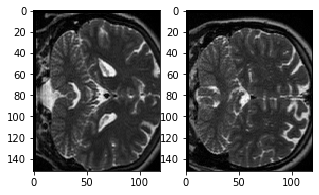

In [70]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[0], (152,120))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[0], (152,120))
plt.imshow(curr_img, cmap='gray')

# Convolutional Autoencoder


In [71]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 16
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 16
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded



In [72]:

batch_size = 32
epochs = 40
inChannel = 1
x, y = 152, 120
input_img = Input(shape = (x, y, inChannel))


In [73]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [74]:
autoencoder.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 152, 120, 1)]     0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 152, 120, 16)      160       
_________________________________________________________________
batch_normalization_30 (Batc (None, 152, 120, 16)      64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 152, 120, 16)      2320      
_________________________________________________________________
batch_normalization_31 (Batc (None, 152, 120, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 76, 60, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 76, 60, 32)        4640

In [75]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Train on 326 samples, validate on 82 samples
Epoch 1/40
326/326 [==============================] - 39s 119ms/sample - loss: 0.1066 - val_loss: 0.0905
Epoch 2/40
326/326 [==============================] - 42s 128ms/sample - loss: 0.0590 - val_loss: 0.0647
Epoch 3/40
326/326 [==============================] - 38s 117ms/sample - loss: 0.0427 - val_loss: 0.0483
Epoch 4/40
326/326 [==============================] - 34s 104ms/sample - loss: 0.0323 - val_loss: 0.0364
Epoch 5/40
326/326 [==============================] - 38s 116ms/sample - loss: 0.0257 - val_loss: 0.0297
Epoch 6/40
326/326 [==============================] - 39s 120ms/sample - loss: 0.0194 - val_loss: 0.0240
Epoch 7/40
326/326 [==============================] - 46s 140ms/sample - loss: 0.0159 - val_loss: 0.0242
Epoch 8/40
326/326 [==============================] - 41s 126ms/sample - loss: 0.0129 - val_loss: 0.0239
Epoch 9/40
326/326 [==============================] - 42s 128ms/sample - loss: 0.0106 - val_loss: 0.0273
Epoch 10/4

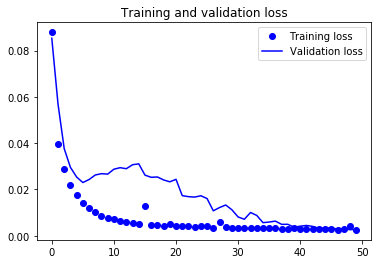

In [54]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Save the Model


In [82]:
autoencoder = Model(input_img, autoencoder(input_img))


TypeError: 'NoneType' object is not callable

In [83]:
pred = autoencoder.predict(valid_X)


AttributeError: 'NoneType' object has no attribute 'predict'